In [1]:
import pandas as pd
import numpy as np
import torch 
%matplotlib inline
import math
import scipy.stats
import time
import torch.utils.data as Data
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.preprocessing import StandardScaler

In [2]:
class Timer:  #@save
    """记录多次运行时间"""
    def __init__(self):
        self.times = []
        self.start()
    def start(self):
        """启动计时器"""
        self.tik = time.time()
    def stop(self):
        """停止计时器并将时间记录在列表中"""
        self.times.append(time.time() - self.tik)
        return self.times[-1]
    def avg(self):
        """返回平均时间"""
        return sum(self.times) / len(self.times)
    def sum(self):
        """返回时间总和"""
        return sum(self.times)
    def cumsum(self):
        """返回累计时间"""
        return np.array(self.times).cumsum().tolist()

In [3]:
train=pd.read_feather('J:/quant_trade/trains.feather')
test=pd.read_feather('J:/quant_trade/tests.feather')

In [4]:
tlist=train.columns.tolist()
tlist=tlist[4:104]
x_train=train[tlist]
y_train=train['1W']
x_test=test[tlist]
y_test=test['1W']

In [5]:
train_xt=torch.from_numpy(x_train.values.astype(np.float32)).cuda()
train_yt=torch.from_numpy(y_train.values.astype(np.float32)).cuda()
test_xt=torch.from_numpy(x_test.values.astype(np.float32)).cuda()
test_yt=torch.from_numpy(y_test.values.astype(np.float32)).cpu()

In [6]:
train=None
test=None
x_train=None
y_train=None
x_test=None
y_test=None

In [7]:
train_data=Data.TensorDataset(train_xt,train_yt)
test_data=Data.TensorDataset(test_xt,test_yt)

In [8]:
info=[]

In [16]:
class MLPrg(nn.Module):
    def __init__(self):
        super(MLPrg,self).__init__()
        self.hidden1=nn.Linear(in_features=100,out_features=196,bias=True)
        self.predict=nn.Linear(196,1)
        self.dropout=nn.Dropout(0.2)
    def forward(self,x):
        x=F.leaky_relu(self.hidden1(x))
        x=self.dropout(x)
        output=self.predict(x)
        return output[:,0]

In [12]:
rg=MLPrg()
rg=rg.cuda()
loss_func=nn.L1Loss()
loss_func=loss_func.cuda()
plt.figure(figsize=(10,6))
optimizer=torch.optim.Adam(rg.parameters(),lr=0.1)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

<Figure size 1000x600 with 0 Axes>

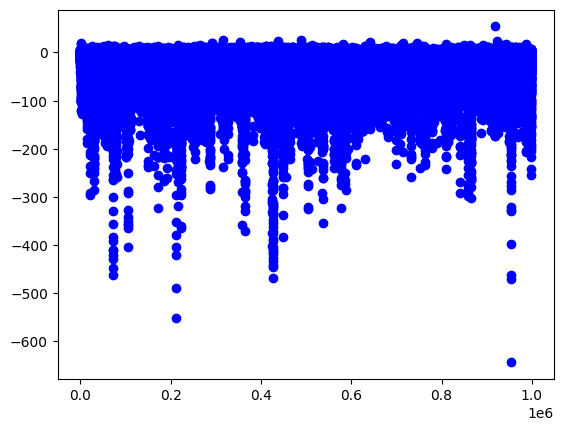

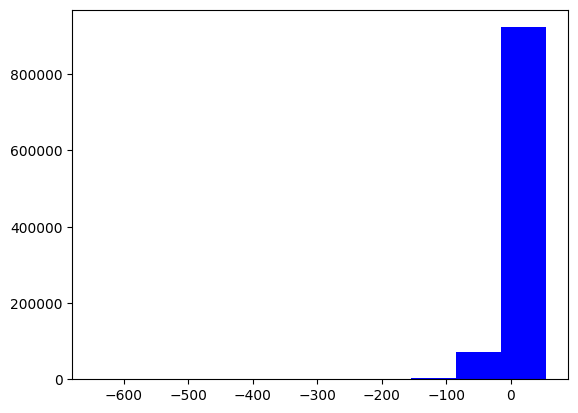

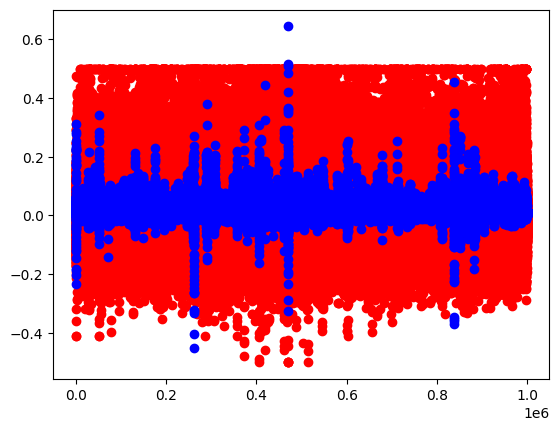

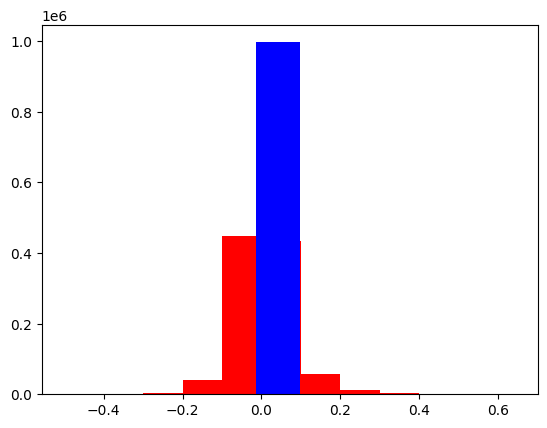

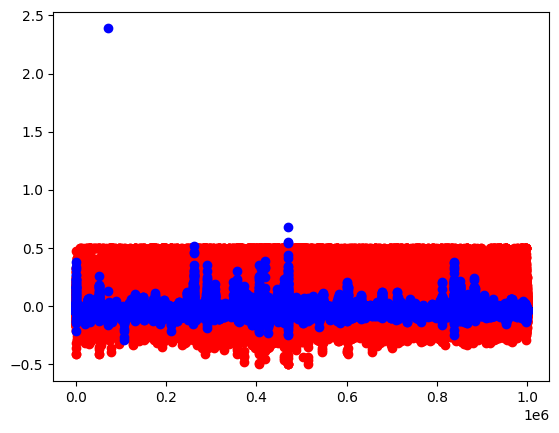

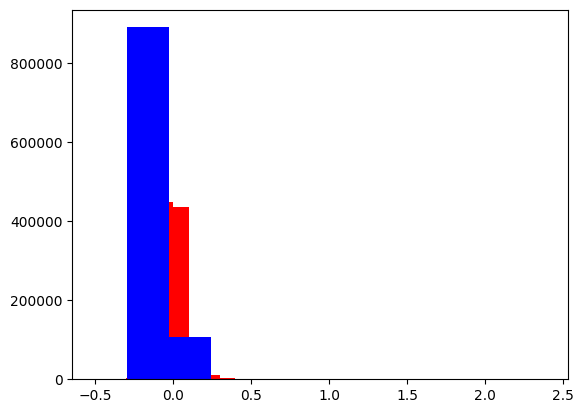

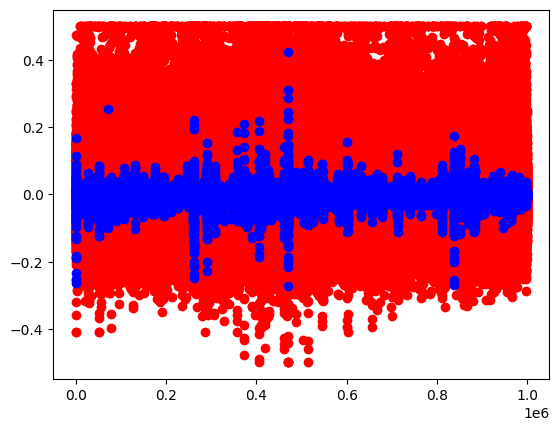

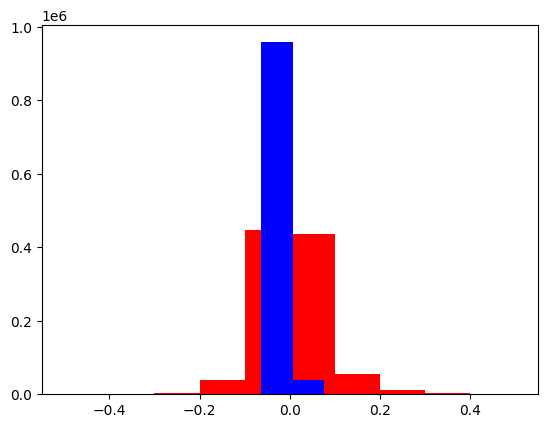

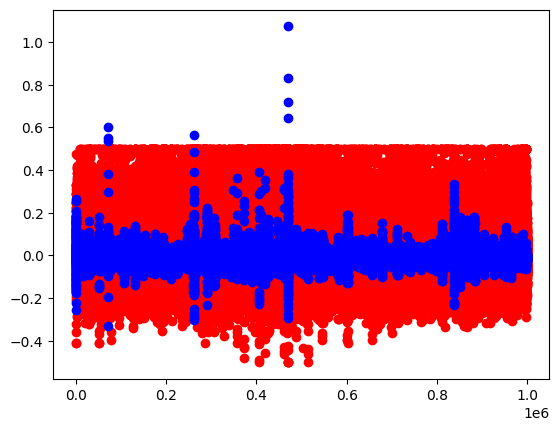

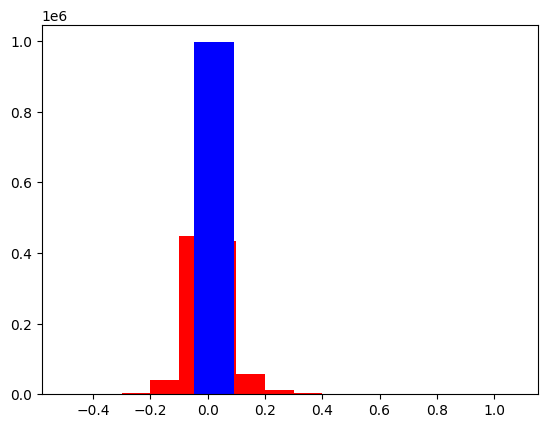

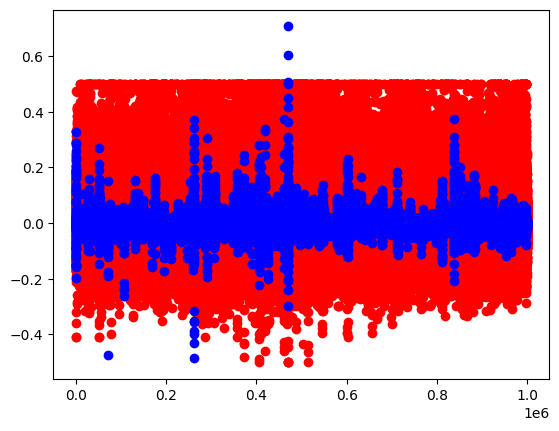

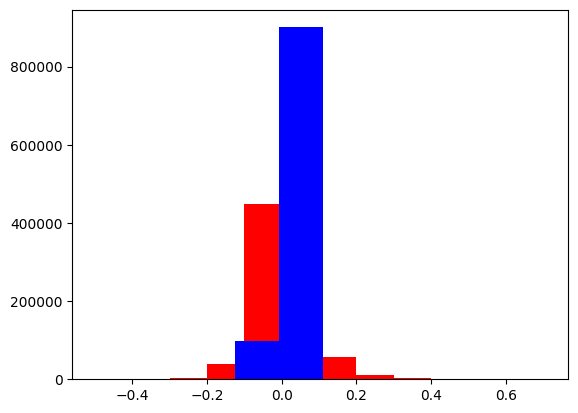

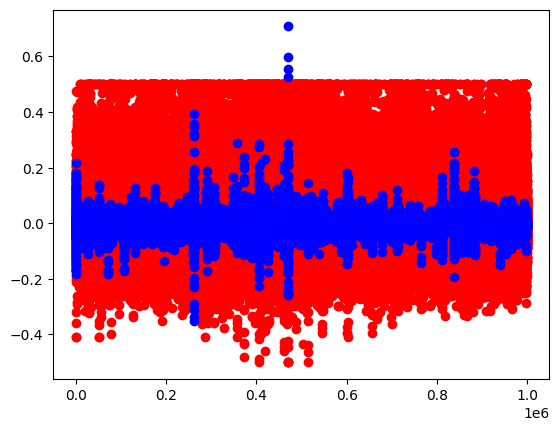

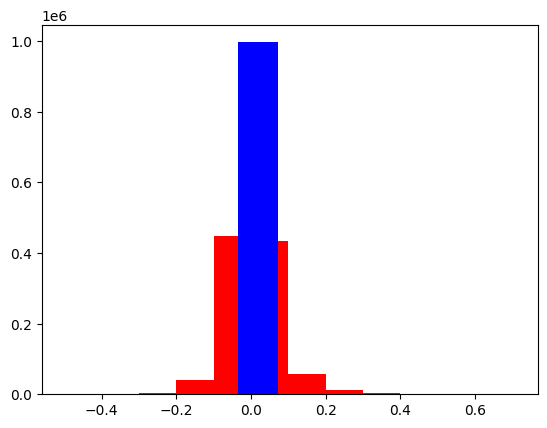

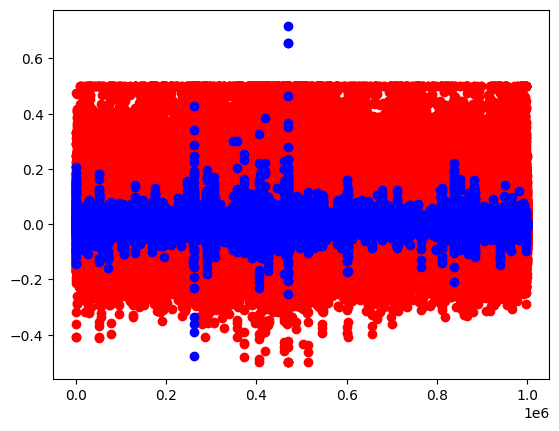

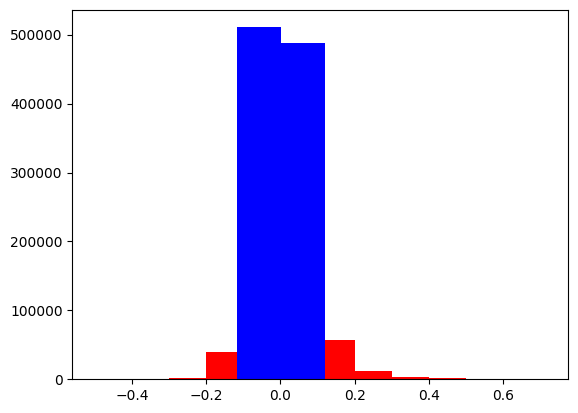

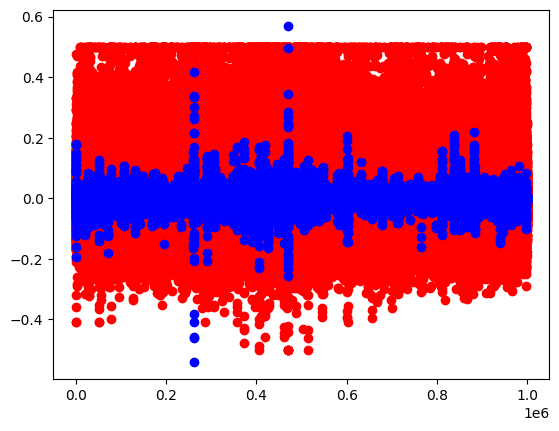

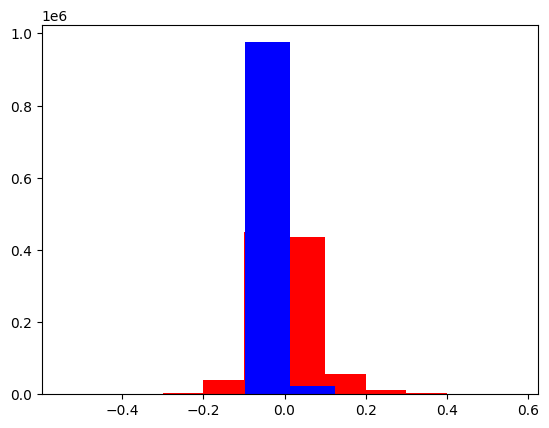

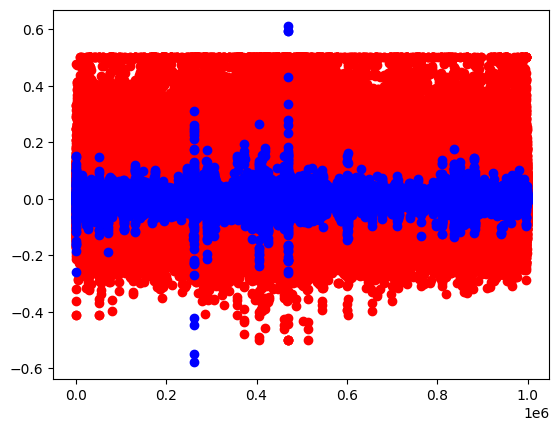

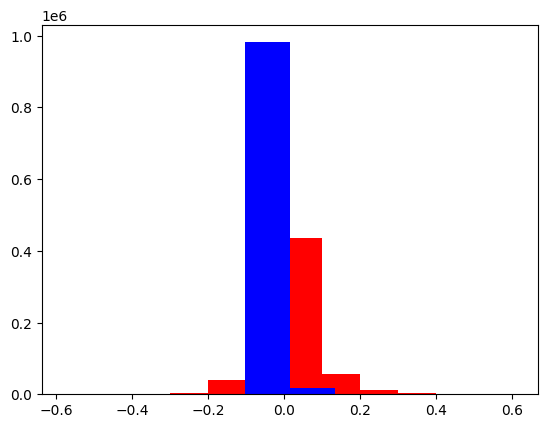

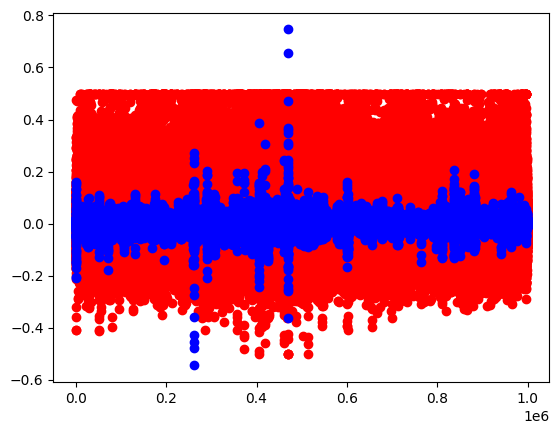

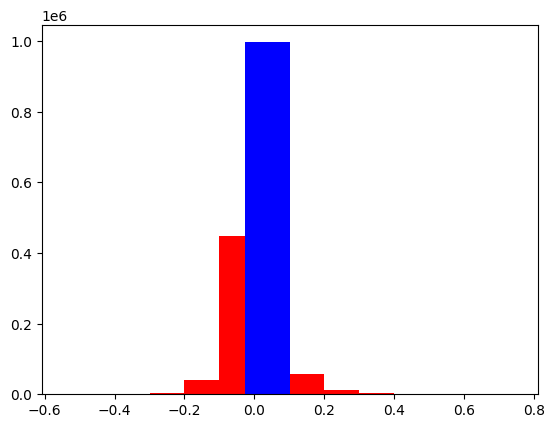

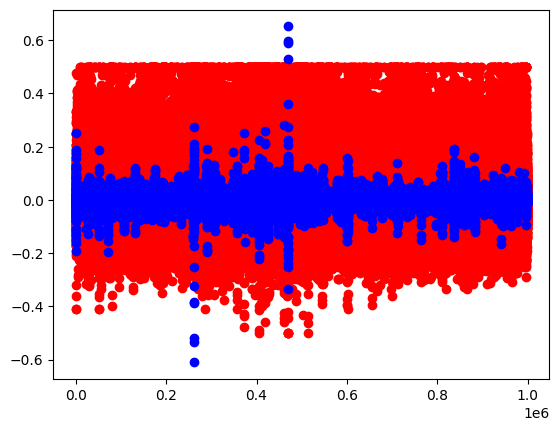

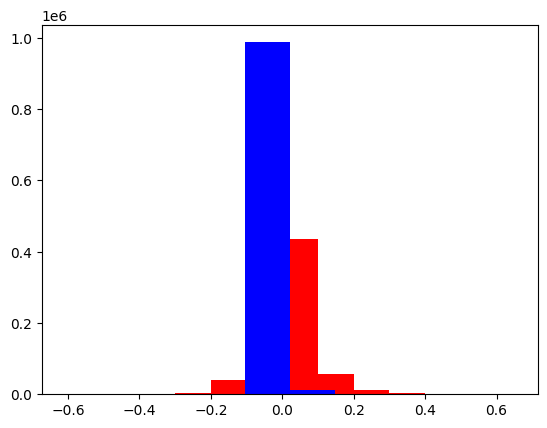

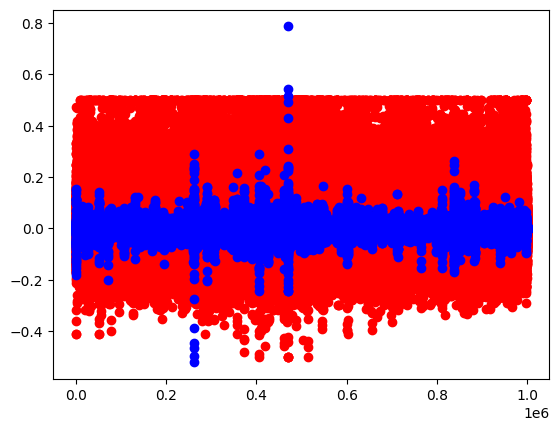

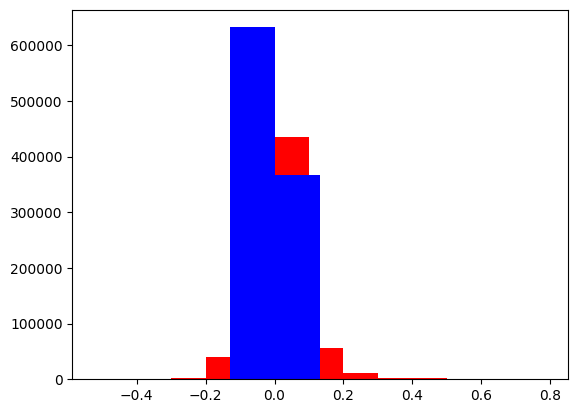

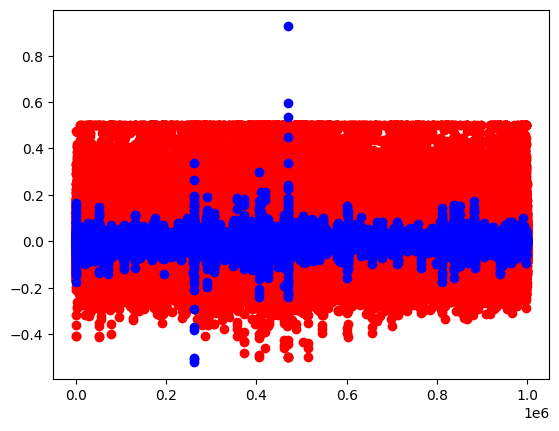

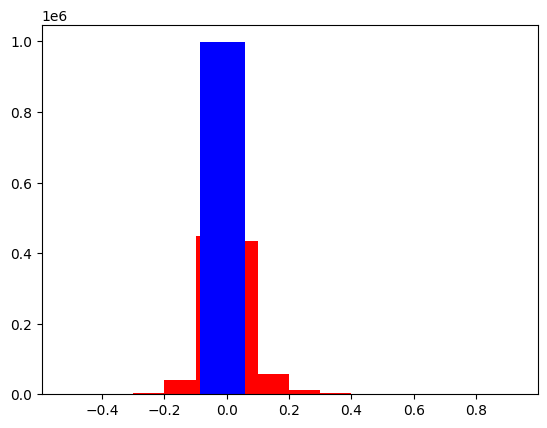

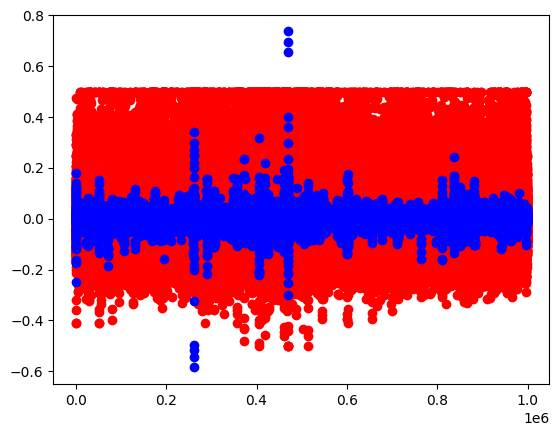

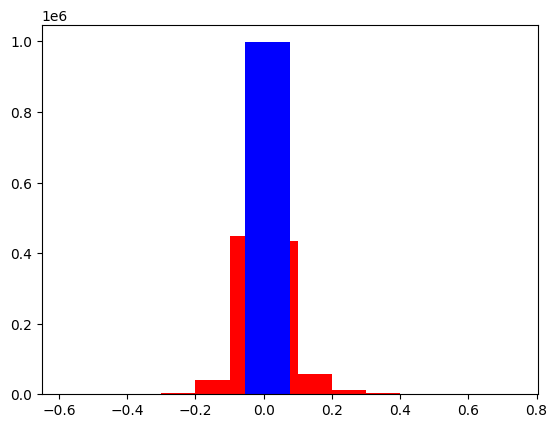

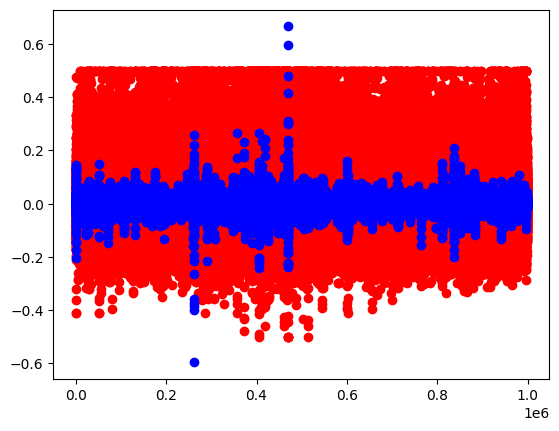

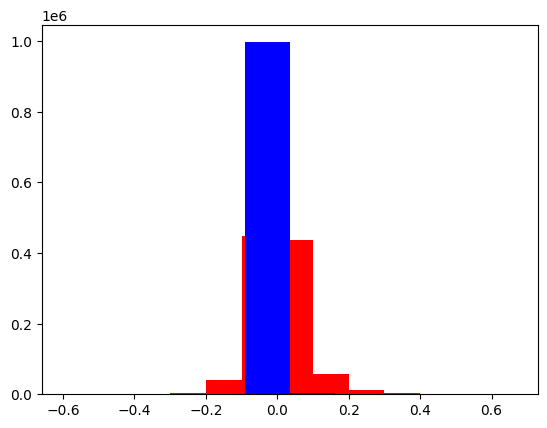

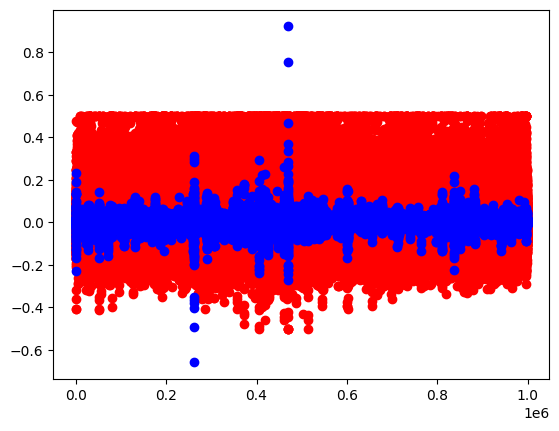

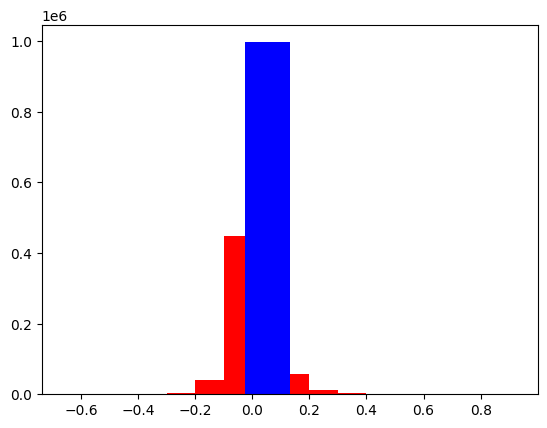

In [ ]:
minks=99999999999999
while True:   
    rg=MLPrg()
    rg=rg.cuda()
    optimizer=torch.optim.Adam(rg.parameters(),lr=0.1)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
    train_loader=Data.DataLoader(dataset=train_data,batch_size=4086,shuffle=True,num_workers=0)
    for epoch in range(1000):
        train_loss=0
        train_num=0
        timer = Timer()
        for step,(b_x,b_y) in enumerate(train_loader):
            b_x=b_x.cuda()
            b_y=b_y.cuda()
            output=rg(b_x)
            loss=loss_func(output,b_y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss+=loss.item()*b_x.size(0)
            train_num+=b_x.size(0)
        scheduler.step()        
        testy=rg(test_xt)
        testy=testy.cpu()
        mae=mean_absolute_error(test_yt.detach().numpy(),testy.detach().numpy())
        df=pd.DataFrame()
        df['real']=test_yt
        df['pre']=testy.detach().numpy()
        idx=scipy.stats.ks_2samp(df['pre'],df['real'])
        ks=scipy.stats.ks_2samp(df['pre'],df['real'])[0]
        minks=min(minks,ks)
        if minks==ks:
            torch.save(rg,'J:/quant_trade/modelbase/bestks.pt')
        plt.scatter(y=df['real'],x=range(df.shape[0]),color='red')
        plt.scatter(y=df['pre'],x=range(df.shape[0]),color='blue')
        plt.show()
        plt.close()
        plt.hist(df['real'],color='red')
        plt.hist(df['pre'],color='blue')
        plt.show()
        plt.close()
        info.append([str(epoch),train_loss/train_num,mae,timer.stop(),ks,idx])
        pd.DataFrame(info).to_html('data.html')

In [22]:
info

[['0',
  3079146.292431712,
  0.3469623,
  0.5339929028503779,
  KstestResult(statistic=0.5339929028503779, pvalue=0.0, statistic_location=0.11111455, statistic_sign=-1)],
 ['1',
  3049531.1719093323,
  0.51556844,
  0.584874838371081,
  KstestResult(statistic=0.584874838371081, pvalue=0.0, statistic_location=-0.123626694, statistic_sign=1)],
 ['2',
  3024043.8978738785,
  0.37426877,
  0.41662852341027756,
  KstestResult(statistic=0.41662852341027756, pvalue=0.0, statistic_location=-0.114287764, statistic_sign=1)],
 ['3',
  620878.4807961583,
  0.07160339,
  0.08102629230521152,
  KstestResult(statistic=0.08102629230521152, pvalue=0.0, statistic_location=-0.03846285, statistic_sign=1)],
 ['4',
  623236.0484058261,
  0.0664523,
  0.03959219934517133,
  KstestResult(statistic=0.03959219934517133, pvalue=0.0, statistic_location=0.112279214, statistic_sign=1)],
 ['5',
  623326.2765721977,
  0.06340092,
  0.10390623669785232,
  KstestResult(statistic=0.10390623669785232, pvalue=0.0, statis

In [1]:
minks

NameError: name 'minks' is not defined